TEST LOADER FOR PHOIBOS 150 DATA

Typical structure 
/2020/01 January/Day 10/Raw Data/8874

Withing the folder of the scan number there is an info.txt and a scan
In THE AVG FOLDER there is a set of images, averaged over every acquisition cycle
IN THE RAW FOLDER there are single acquisition cycles (difference: in EPFL we added the "save every n cycle function"
this RAW folder also contains a "LUT.txt" file

In [104]:
from importlib import reload
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
spa = SpecsAnalyzer()

import os
exampledatapath='../tests/data/dataEPFL/9159/'
filelist=os.listdir(exampledatapath)
print("example data path= ",exampledatapath)
#this folders contains the AVG folder with the data, an info.txt vector and a scan vector

#navigate to the image folder, for EPFL in the \AVG subfolder of the data
avgimagepath='../tests/data/dataEPFL/9159/AVG'
print("AVG images path= ",avgimagepath)
rawimagelist=os.listdir(avgimagepath)


example data path=  ../tests/data/dataEPFL/9159/
AVG images path=  ../tests/data/dataEPFL/9159/AVG


The shape of the raw data is:  (256, 344)


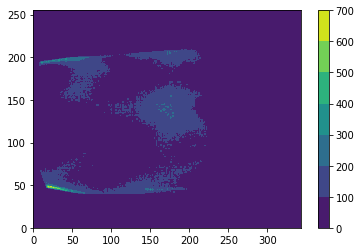

In [105]:
raw_image_name=os.path.join(avgimagepath,rawimagelist[0]) 
with open(raw_image_name) as file:
    tsv_data = np.loadtxt(file, delimiter='\t')
plt.figure()
h = plt.contourf(tsv_data)
plt.colorbar()
print("The shape of the raw data is: ",tsv_data.shape)
#plt.xlim(120,150)
#plt.ylim(150,200)


In [106]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
spa = SpecsAnalyzer()
scanparameters=spa.return_config()

In [107]:
#load the module and import functions for reading the parameter table from the calib2d file
import specsanalyzer.convert
reload(specsanalyzer.convert)   


#let's get all the functions to be tested
from specsanalyzer.convert import get_damatrix_fromcalib2d
from specsanalyzer.convert import get_rr_da
from specsanalyzer.convert import calculate_polynomial_coef_da
from specsanalyzer.convert import mcp_position_mm


In [108]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# call an instance of the class 
spa = SpecsAnalyzer()
# io function used to get the calib 2d file in the class
calib2d_dictionary=specsanalyzer.io.parse_calib2d_to_dict('../tests/data/dataEPFL/phoibosEPFL.calib2d')
# settings function used to get  configuration files  
config_file=specsanalyzer.settings.parse_config(calib2d_dictionary)



#get the das  and the rr vector 
#rr_array, da_matrix=  specsanalyzer.convert.get_rr_da("WideAngleMode", config_file)

In [109]:
# Load the IGOR txt Di_coeff values for comparison
igordatapath='../tests/data/dataEPFL/igor_R9159'
igordatapath_content=os.listdir(igordatapath)

# get the fitted coefficients
Di_coef_list= [i for i in igordatapath_content if "_coef" in i ]

igor_D_coef_list=[]
for i,name in enumerate(Di_coef_list):
    tmp_name=os.path.join(igordatapath,name) 
    with open(tmp_name) as file:
        #check the name in row 1
        #first_line=file.readline()
        #print(first_line)

        igor_D_coef_list.append(np.loadtxt(file, delimiter='\t', skiprows=1) )
igor_D_coef_matrix=np.vstack(igor_D_coef_list)
igor_D_coef_matrix  #row 0 D1 , row 1 D3, ...



array([[-9.0677557e+00,  5.4180306e-01, -7.4833869e-03],
       [ 3.7976568e+00, -2.6664829e-01,  4.5543350e-03],
       [-9.6360517e-01,  8.5502811e-02, -1.6958975e-03],
       [-2.3122853e-01,  4.3503465e-03,  7.1996968e-05]])

In [110]:
# Load the IGOR txt Da_values for comparison
igordatapath='../tests/data/dataEPFL/igor_R9159'
igordatapath_content=os.listdir(igordatapath)

# get the fitted coefficients
Di_value_list= [i for i in igordatapath_content if "_value" in i ]

igor_D_value_list=[]
for i,name in enumerate(Di_value_list):
    tmp_name=os.path.join(igordatapath,name) 
    with open(tmp_name) as file:
        #check the name in row 1
        #first_line=file.readline()
        #print(first_line)

        igor_D_value_list.append(np.loadtxt(file, delimiter='\t', skiprows=1) )
igor_D_value_matrix=np.vstack(igor_D_value_list)




In [111]:
# use the EPFL CONFIGURATION FILE

spa = SpecsAnalyzer(config="../tests/data/dataEPFL/config/config.yaml")
config_dict=spa.return_config()

lens_mode="WideAngleMode"
kinetic_energy=35.5
pass_energy=25
print(kinetic_energy/pass_energy)
eshift = np.array(config_dict[
        "calib2d_dict"
    ]["eShift"])

aInner, damatrix = get_damatrix_fromcalib2d(
    lens_mode,
    kinetic_energy,
    pass_energy,
    config_dict
    )

dapolymatrix = calculate_polynomial_coef_da(
    damatrix,
    kinetic_energy,
    pass_energy,
    eshift)


# note that for scan 9159 we have   rr_inf =   13  rr_factor =   0.504
# now we get the rr factor of 0.83, why??
#  at rr[13] we have rr=1 and at rr[14] we have rr=1.5
# the work function did the trick, set to 1.42, have to check with Laurenz
# what they set in the labview..




1.42
closest_rr_index=  13
rr_factor=  0.5039999999999996


In [112]:
print("das")
print(damatrix)
print(igor_D_value_matrix)

print(damatrix-igor_D_value_matrix)
# at the moment they differ by some %.. 

print("coefs")
print(dapolymatrix)
print(igor_D_coef_matrix)

print(dapolymatrix-igor_D_coef_matrix)
# at the moment they differ by some %.. 


das
[[ 0.7105184   0.7353144   0.7367248 ]
 [ 0.00747262  0.07124336  0.1492464 ]
 [-0.02452784 -0.0655104  -0.11179264]
 [ 0.00222779  0.01394296  0.02588312]]
[[ 0.71051836  0.73531437  0.73672479]
 [ 0.00747262  0.07124336  0.14924639]
 [-0.02452784 -0.0655104  -0.11179264]
 [ 0.00222779  0.01394296  0.02588312]]
[[ 4.00000000e-08  3.00000000e-08  9.99999994e-09]
 [-1.00000004e-10 -1.00000001e-09  9.99999999e-09]
 [ 3.46944695e-18  0.00000000e+00  2.77555756e-17]
 [-1.30104261e-18 -3.46944695e-18 -3.46944695e-18]]
coefs
[[-7.48339200e-03  5.41803392e-01 -9.06776125e+00]
 [ 4.55433728e-03 -2.66648436e-01  3.79765930e+00]
 [-1.69589760e-03  8.55028096e-02 -9.63605190e-01]
 [ 7.19969280e-05  4.35034995e-03 -2.31228592e-01]]
[[-9.0677557e+00  5.4180306e-01 -7.4833869e-03]
 [ 3.7976568e+00 -2.6664829e-01  4.5543350e-03]
 [-9.6360517e-01  8.5502811e-02 -1.6958975e-03]
 [-2.3122853e-01  4.3503465e-03  7.1996968e-05]]
[[ 9.06027231e+00  3.31999902e-07 -9.06027786e+00]
 [-3.79310246e+00 -1.4

In [113]:
# get the rr and the damatrix
rr, damatrix= get_rr_da("WideAngleMode",config_dict)


In [114]:
print(ek_axis.shape)
print(angle_axis.shape)
print(corrected_data.shape)
colorlevels=np.linspace(0,130000,100)
h = plt.contourf(ek_axis,angle_axis,corrected_data,levels=colorlevels)
plt.colorbar()
#plt.xlim(34,37)
#plt.ylim(-15,15)

NameError: name 'ek_axis' is not defined

In [ ]:
# For the example scan we have the following settings:
ek=float(scanparameters["KineticEnergy"])
ep=float(scanparameters["PassEnergy"])
erange=scanparameters["eRange"]
arange=scanparameters["aRange"]
angles=np.linspace(-20,20,1024)
energies=np.linspace(ek+ep*erange[0],ek+ep*erange[1],2048)
ainner=15
energymesh,anglemesh=np.meshgrid(energies,angles)

testimage=mcp_position_mm(energymesh,anglemesh,scanparameters)

KeyError: 'KineticEnergy'

In [ ]:
x = [1e-5, 1000, 1e-1]

y = np.arccos(np.cos(x))

a=np.testing.assert_allclose(x, y, rtol=1e-5, atol=0)
print(a)

AssertionError: 
Not equal to tolerance rtol=1e-05, atol=0

Mismatched elements: 1 / 3 (33.3%)
Max absolute difference: 999.02646384
Max relative difference: 1026.18321382
 x: array([1.e-05, 1.e+03, 1.e-01])
 y: array([1.000000e-05, 9.735362e-01, 1.000000e-01])

In [ ]:
h = plt.contourf(angle_axis,ek_axis,corrected_data.transpose(),levels=colorlevels)
plt.colorbar()

In [ ]:
Di_coef_list

['D1_coef.txt', 'D3_coef.txt', 'D5_coef.txt', 'D7_coef.txt']